In [7]:
import numpy as np
from fontTools.misc.cython import returns
from keras.src.utils.module_utils import tensorflow


def generate_lstm_data(df, feature_cols, target_col, n_lags=48, forecast_horizon=24):
    X, y = [], []
    for i in range(n_lags, len(df) - forecast_horizon):
        X_seq = df[feature_cols].iloc[i - n_lags:i].values
        try:
            y_target = float(df[target_col].iloc[i + forecast_horizon])
        except (ValueError, TypeError, IndexError):
            continue

        if np.isfinite(X_seq).all() and np.isfinite(y_target):
            X.append(X_seq)
            y.append(y_target)
    return np.array(X), np.array(y)

In [8]:
import pandas as pd

df = pd.read_csv("cmc_market_hourly.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.sort_values("timestamp").reset_index(drop=True)

df.head()

,timestamp,total_market_cap,total_volume_24h,total_volume_24h_reported,altcoin_market_cap,altcoin_volume_24h,altcoin_volume_24h_reported
0,2025-03-20 00:05:00+00:00,2.852929e+12,1.014235e+11,6.174540e+11,1.119836e+12,6.697963e+10,3.924743e+11
1,2025-03-20 00:10:00+00:00,2.853917e+12,1.020305e+11,6.219559e+11,1.120613e+12,6.734505e+10,3.940602e+11
2,2025-03-20 00:15:00+00:00,2.853543e+12,1.024006e+11,6.245771e+11,1.121208e+12,6.739788e+10,3.950990e+11
3,2025-03-20 00:20:00+00:00,2.847146e+12,1.025989e+11,6.256588e+11,1.118193e+12,6.722145e+10,3.954406e+11
4,2025-03-20 00:25:00+00:00,2.839911e+12,1.014993e+11,6.269865e+11,1.116159e+12,6.717532e+10,3.961300e+11


In [9]:
df["log_total_volume_24h"] = np.log(df["total_volume_24h"])
df["log_altcoin_volume_24h"] = np.log(df["altcoin_volume_24h"])

feature_cols = ["log_total_volume_24h", "log_altcoin_volume_24h"]
target_col = "log_total_volume_24h"
X_lstm, y_lstm = generate_lstm_data(df, feature_cols, target_col, n_lags=48, forecast_horizon=24)

Epoch 1/30


/Users/dariapavlova/Documents/defi_trends_analysis/.ven311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0196 - val_loss: 0.0022
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 5/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 6/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 9/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 10/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 11/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0022 - val_loss: 9.9441e-04
Epoch 12/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39m

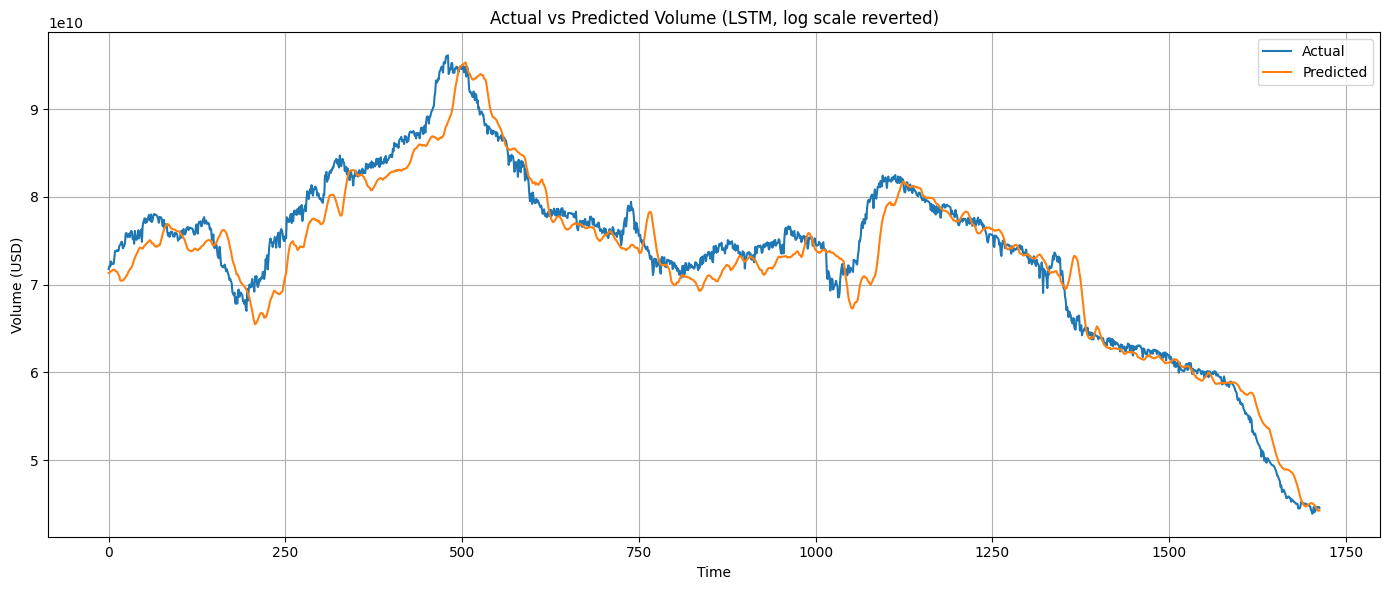

In [65]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

y_pred_scaled = model.predict(X_test_scaled)
y_pred = np.exp(np.clip(y_scaler.inverse_transform(y_pred_scaled), a_min=None, a_max=709))
y_actual = np.exp(np.clip(y_scaler.inverse_transform(y_test_scaled), a_min=None, a_max=709))

plt.figure(figsize=(14, 6))
plt.plot(y_actual, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Volume (LSTM, log scale reverted)")
plt.xlabel("Time")
plt.ylabel("Volume (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 0.03
RMSE: 0.04
R²: 0.9394


In [76]:
df["log_val"] = np.log(df["total_volume_24h"])
df["log_alt_val"] = np.log(df["altcoin_volume_24h"])

def make_multi_step(df, feature_cols, target_col, n_lags, forecast_horizon):
    X, y = [], []
    for i in range(n_lags, len(df) - forecast_horizon + 1):
        X.append(df[feature_cols].iloc[i - n_lags:i].values)
        y.append(df[target_col].iloc[i:i + forecast_horizon].values)
    return np.array(X), np.array(y)

feature_cols = ["log_val", "log_alt_val"]
X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=5)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [79]:
model = Sequential(
    [
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dense(32, activation="relu"),
        Dense(5)
    ]
)
model.compile(optimizer=Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

/Users/dariapavlova/Documents/defi_trends_analysis/.ven311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,397 (75.77 KB)

 Trainable params: 19,397 (75.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0522 - val_loss: 3.9839e-04
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0472e-04 - val_loss: 1.4952e-04
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8665e-04 - val_loss: 9.7103e-05
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.9255e-04 - val_loss: 7.4756e-05
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5367e-04 - val_loss: 6.7011e-05
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4105e-04 - val_loss: 7.1782e-05
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2756e-04 - val_loss: 7.2622e-05
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3421e-04 - val_loss: 6.9482e-05
Epoch 9/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1691e-04 - val_loss: 9.8801e-05
Epoch 10/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1017e-04 - val_loss: 7.2435e-05
Epoch 11/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Step 1 - MAE: 644384675.68, R²: 0.9935
Step 2 - MAE: 657749416.91, R²: 0.9930
Step 3 - MAE: 680855447.73, R²: 0.9922
Step 4 - MAE: 776935330.07, R²: 0.9901
Step 5 - MAE: 874693239.10, R²: 0.9874


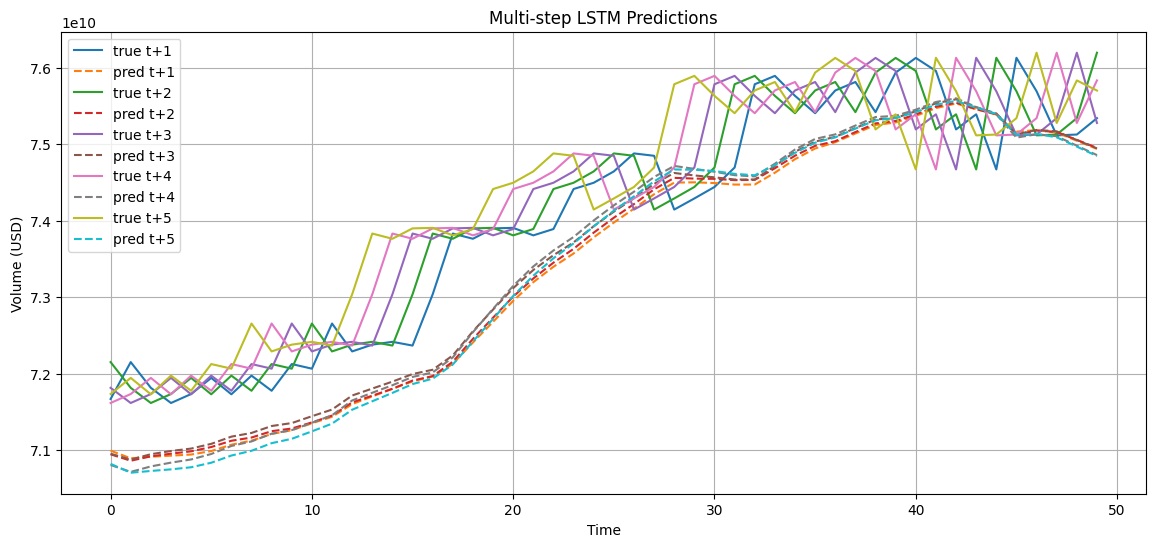

In [82]:
y_pred_scaled = model.predict(X_test)

y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

y_test_vol = np.exp(y_test_log)
y_pred_vol = np.exp(y_pred_log)

for step in range(5):
    true = y_test_vol[:, step]
    pred = y_pred_vol[:, step]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"Step {step + 1} - MAE: {mae:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(14, 6))
for step in range(5):
    plt.plot(y_test_vol[:50, step], label=f"true t+{step + 1}")
    plt.plot(y_pred_vol[:50, step], "--", label=f"pred t+{step + 1}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Volume (USD)")
plt.title("Multi-step LSTM Predictions")
plt.grid(True)
plt.show()

In [84]:
rolling_window = 12

df["vol_mean_12"] = df["log_val"].rolling(window=rolling_window).mean()
df["vol_std_12"] = df["log_val"].rolling(window=rolling_window).std()
df["alt_mean_12"] = df["log_alt_val"].rolling(window=rolling_window).mean()
df["alt_std_12"] = df["log_alt_val"].rolling(window=rolling_window).std()

df["vol_pct_1"] = df["log_val"].pct_change(periods=1)
df["alt_pct_1"] = df["log_alt_val"].pct_change(periods=1)

df = df.dropna().reset_index(drop=True)

feature_cols = [
    "log_val", "log_alt_val",
    "vol_mean_12", "vol_std_12",
    "alt_mean_12", "alt_std_12",
    "vol_pct_1", "alt_pct_1"
]

In [85]:
X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=5)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [86]:
model = Sequential(
    [
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dense(32, activation="relu"),
        Dense(5)
    ]
)
model.compile(optimizer=Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

/Users/dariapavlova/Documents/defi_trends_analysis/.ven311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,933 (81.77 KB)

 Trainable params: 20,933 (81.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0421 - val_loss: 2.0887e-04
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.3862e-04 - val_loss: 1.8515e-04
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.2881e-04 - val_loss: 1.3890e-04
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2848e-04 - val_loss: 8.8387e-05
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6864e-04 - val_loss: 8.6006e-05
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3361e-04 - val_loss: 5.5009e-05
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2415e-05 - val_loss: 7.4957e-05
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.1273e-05 - val_loss: 6.0797e-05
Epoch 9/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4213e-05 - val_loss: 4.3734e-05
Epoch 10/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3706e-05 - val_loss: 5.4750e-05
Epoch 11/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Step 1 - MAE: 407292535.35, R²: 0.9970
Step 2 - MAE: 511885725.77, R²: 0.9953
Step 3 - MAE: 643245093.02, R²: 0.9931
Step 4 - MAE: 696643031.97, R²: 0.9919
Step 5 - MAE: 755411846.31, R²: 0.9905


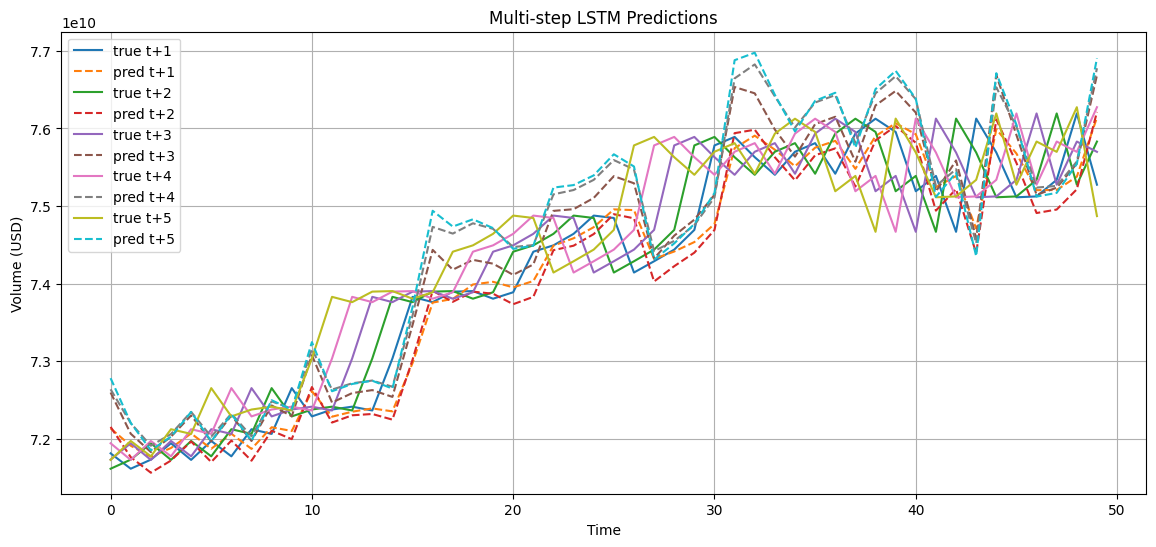

In [87]:
y_pred_scaled = model.predict(X_test)

y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

y_test_vol = np.exp(y_test_log)
y_pred_vol = np.exp(y_pred_log)

for step in range(5):
    true = y_test_vol[:, step]
    pred = y_pred_vol[:, step]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"Step {step + 1} - MAE: {mae:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(14, 6))
for step in range(5):
    plt.plot(y_test_vol[:50, step], label=f"true t+{step + 1}")
    plt.plot(y_pred_vol[:50, step], "--", label=f"pred t+{step + 1}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Volume (USD)")
plt.title("Multi-step LSTM Predictions")
plt.grid(True)
plt.show()

In [89]:
from keras import Input
from tensorflow.keras.callbacks import EarlyStopping

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_ahead = y_train.shape[1]

model = Sequential(
    [
        Input(shape=(n_timesteps, n_features)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(n_ahead),
    ]
)

model.compile(optimizer=Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        )
    ]
)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 48, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,797 (475.77 KB)

 Trainable params: 121,797 (475.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0519 - val_loss: 4.9445e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0039 - val_loss: 3.0526e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0025 - val_loss: 1.1216e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0021 - val_loss: 1.3106e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0014 - val_loss: 2.1428e-04
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0013 - val_loss: 8.4357e-05
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 9.9483e-04 - val_loss: 1.0878e-04
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 8.7601e-04 - val_loss: 5.1987e-05
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 8.9319e-04 - val_loss: 1.3881e-04
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 8.1070e-04 - val_lo

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Step 1 - MAE: 463674812.43, R²: 0.9964
Step 2 - MAE: 494225035.36, R²: 0.9957
Step 3 - MAE: 529687358.14, R²: 0.9949
Step 4 - MAE: 606848559.79, R²: 0.9934
Step 5 - MAE: 686027343.73, R²: 0.9919


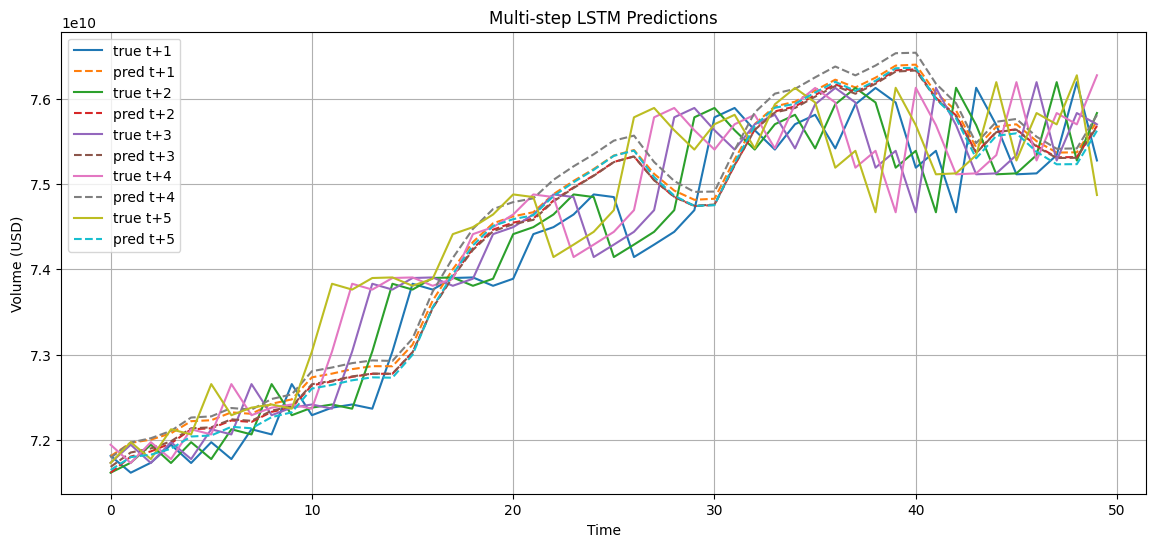

In [90]:
y_pred_scaled = model.predict(X_test)

y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

y_test_vol = np.exp(y_test_log)
y_pred_vol = np.exp(y_pred_log)

for step in range(5):
    true = y_test_vol[:, step]
    pred = y_pred_vol[:, step]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"Step {step + 1} - MAE: {mae:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(14, 6))
for step in range(5):
    plt.plot(y_test_vol[:50, step], label=f"true t+{step + 1}")
    plt.plot(y_pred_vol[:50, step], "--", label=f"pred t+{step + 1}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Volume (USD)")
plt.title("Multi-step LSTM Predictions")
plt.grid(True)
plt.show()

In [91]:
X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=12)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [92]:
from keras import Input
from tensorflow.keras.callbacks import EarlyStopping

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_ahead = y_train.shape[1]

model = Sequential(
    [
        Input(shape=(n_timesteps, n_features)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(12),
    ]
)

model.compile(optimizer=Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
        )
    ]
)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 48, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,028 (476.67 KB)

 Trainable params: 122,028 (476.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0562 - val_loss: 2.9438e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0047 - val_loss: 1.6978e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0029 - val_loss: 3.6419e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0022 - val_loss: 1.2063e-04
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0018 - val_loss: 1.7759e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0014 - val_loss: 1.0398e-04
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0012 - val_loss: 9.6837e-05
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0011 - val_loss: 1.7350e-04
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 8.8981e-04 - val_loss: 8.4437e-05
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 7.8919e-04 - val_loss: 1.0064e-04
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 8.1216e-04 - val_lo

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Step 1 - MAE: 587790618.56, R²: 0.9941
Step 2 - MAE: 632730806.02, R²: 0.9932
Step 3 - MAE: 667081999.86, R²: 0.9925
Step 4 - MAE: 643517365.33, R²: 0.9927
Step 5 - MAE: 702618411.45, R²: 0.9913
Step 6 - MAE: 780995347.78, R²: 0.9895
Step 7 - MAE: 779304891.72, R²: 0.9889
Step 8 - MAE: 817789962.36, R²: 0.9877
Step 9 - MAE: 882831077.06, R²: 0.9858
Step 10 - MAE: 923378487.43, R²: 0.9842
Step 11 - MAE: 973901705.10, R²: 0.9827
Step 12 - MAE: 1025517026.45, R²: 0.9806


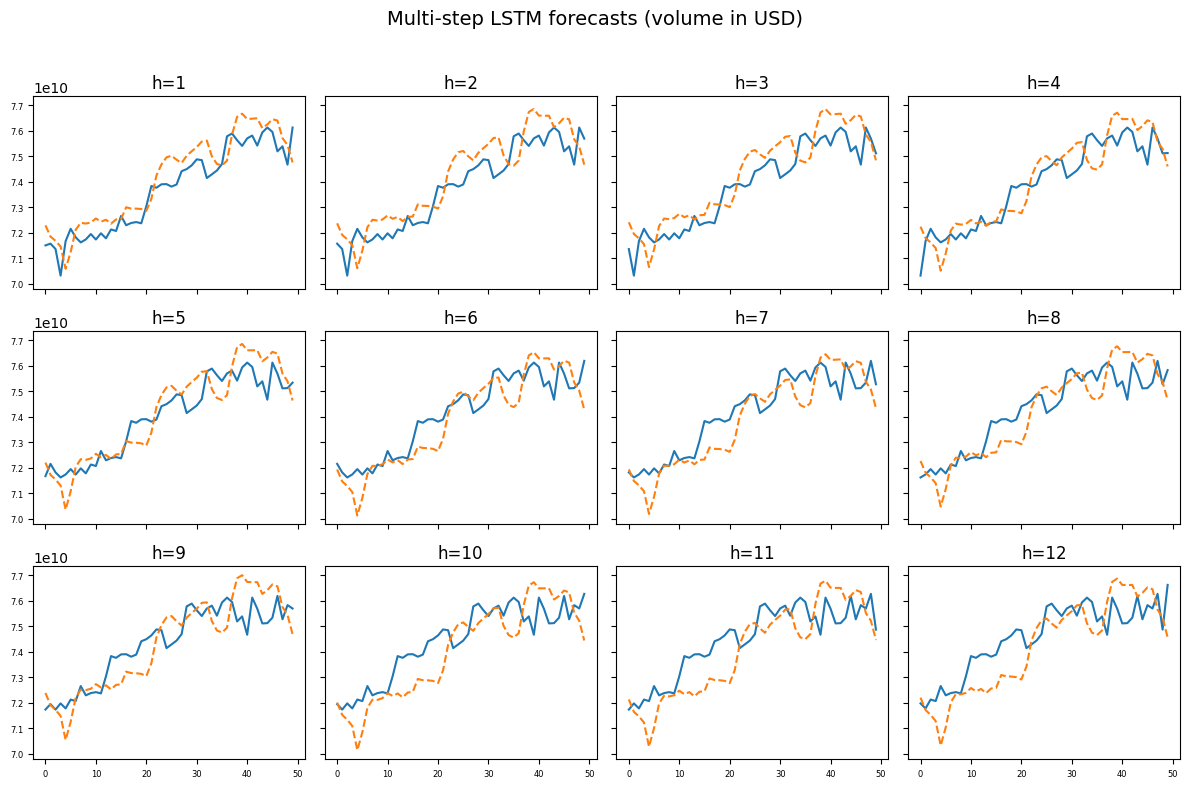

In [96]:
n_ahead = 12
y_pred_scaled = model.predict(X_test)

y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

y_test_vol = np.exp(y_test_log)
y_pred_vol = np.exp(y_pred_log)

for step in range(12):
    true = y_test_vol[:, step]
    pred = y_pred_vol[:, step]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"Step {step + 1} - MAE: {mae:.2f}, R²: {r2:.4f}")

K = 50
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,8), sharex=True, sharey=True)
axes = axes.flatten()

for h in range(n_ahead):
    ax = axes[h]
    ax.plot(y_test_vol[:K, h],    label=f"true t+{h+1}", color="C0")
    ax.plot(y_pred_vol[:K, h], "--",label=f"pred t+{h+1}", color="C1")
    ax.set_title(f"h={h+1}")
    ax.tick_params(labelsize=6)

for ax in axes[n_ahead:]:
    ax.axis("off")

fig.suptitle("Multi-step LSTM forecasts (volume in USD)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [97]:
X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=48)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [98]:
from keras import Input
from tensorflow.keras.callbacks import EarlyStopping

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_ahead = y_train.shape[1]

model = Sequential(
    [
        Input(shape=(n_timesteps, n_features)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(n_ahead),
    ]
)

model.compile(optimizer=Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
        )
    ]
)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 48, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,216 (481.31 KB)

 Trainable params: 123,216 (481.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.1043 - val_loss: 7.3375e-04
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0053 - val_loss: 7.2404e-04
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0036 - val_loss: 5.2565e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0029 - val_loss: 4.9644e-04
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0024 - val_loss: 5.5733e-04
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0022 - val_loss: 4.0829e-04
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0021 - val_loss: 6.3243e-04
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0020 - val_loss: 6.3185e-04
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0017 - val_loss: 4.6765e-04
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0017 - val_loss: 4.3719e-04
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0016 - val_loss: 6.3774e-

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Step 1 - MAE: 1193875215.64, R²: 0.9730
Step 2 - MAE: 1107247705.78, R²: 0.9762
Step 3 - MAE: 1331406391.79, R²: 0.9683
Step 4 - MAE: 1049310207.03, R²: 0.9784
Step 5 - MAE: 1193005482.29, R²: 0.9742
Step 6 - MAE: 1089834699.51, R²: 0.9776
Step 7 - MAE: 1007921395.54, R²: 0.9791
Step 8 - MAE: 1202221905.16, R²: 0.9715
Step 9 - MAE: 1310212015.36, R²: 0.9685
Step 10 - MAE: 1469886287.77, R²: 0.9618
Step 11 - MAE: 1491402327.51, R²: 0.9608
Step 12 - MAE: 1307854861.05, R²: 0.9668
Step 13 - MAE: 1258222043.21, R²: 0.9678
Step 14 - MAE: 1233802134.30, R²: 0.9668
Step 15 - MAE: 1492520539.28, R²: 0.9573
Step 16 - MAE: 1422229909.74, R²: 0.9587
Step 17 - MAE: 1452799595.07, R²: 0.9566
Step 18 - MAE: 1525557255.51, R²: 0.9533
Step 19 - MAE: 1523254680.47, R²: 0.9531
Step 20 - MAE: 1600499423.28, R²: 0.9492
Step 21 - MAE: 1577641875.93, R²: 0.9495
Step 22 - MAE: 1820188994.20, R²: 0.9380
Step 23 - MAE: 1759614597.41, R²: 0.9400
Step 24 - MAE: 1716524803.

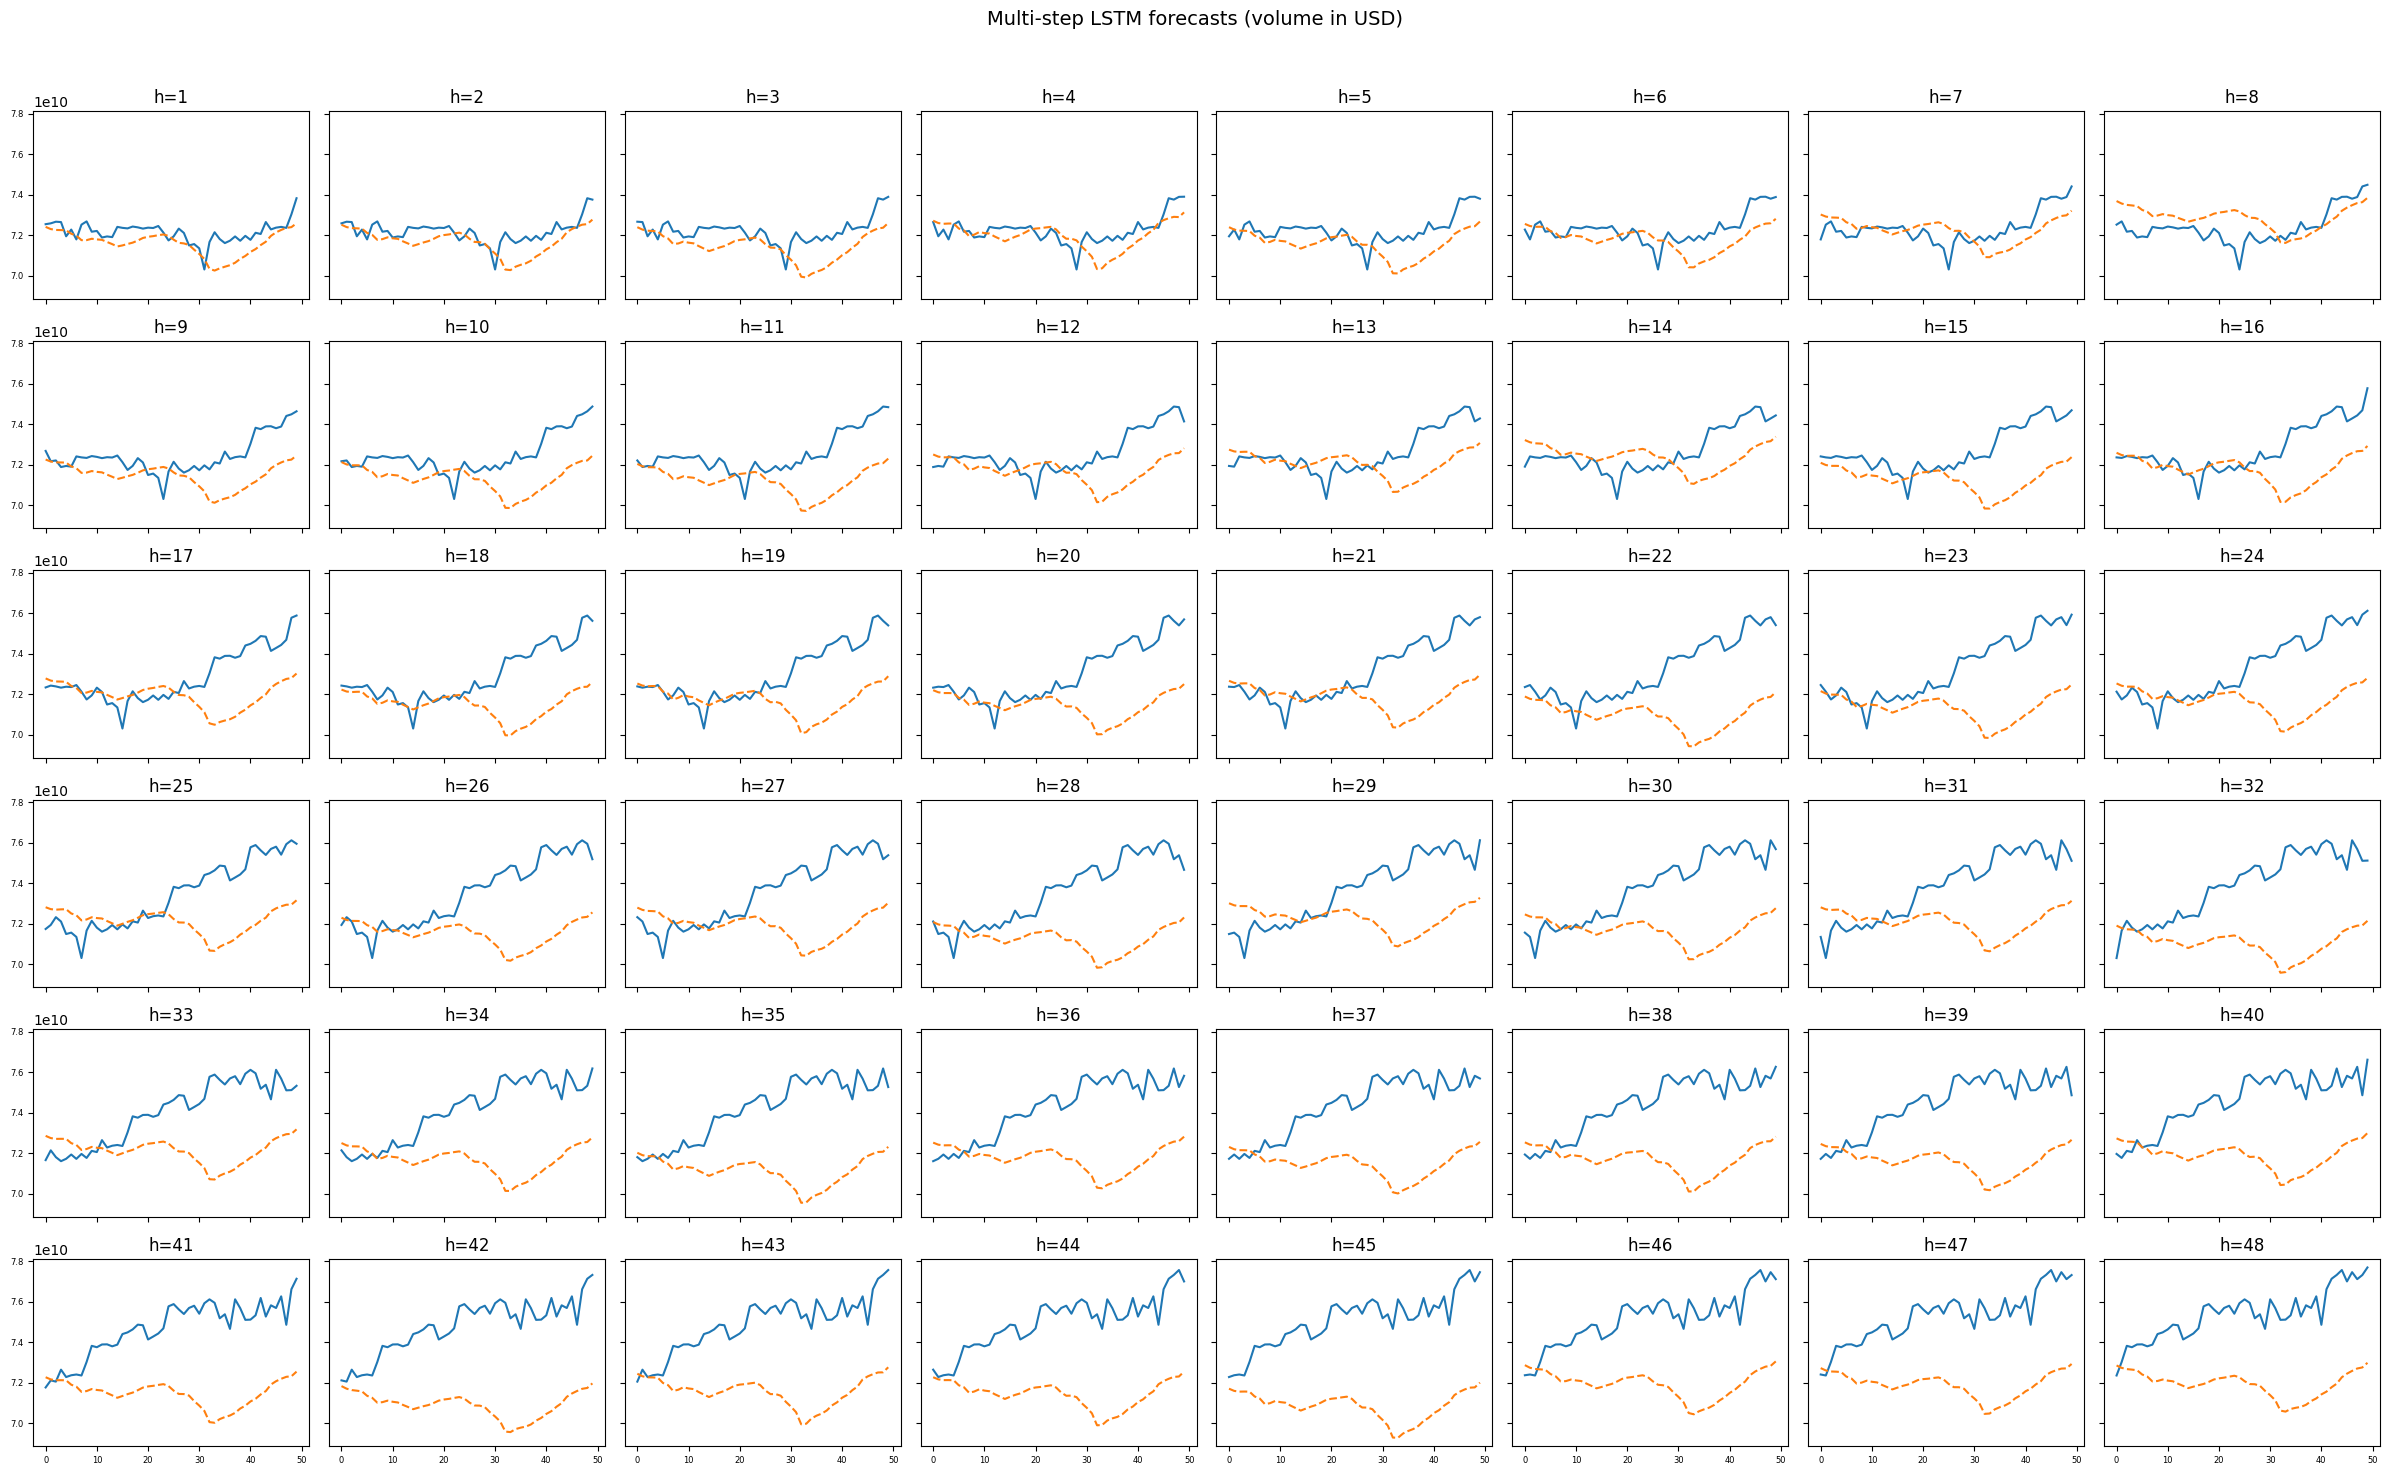

In [102]:
y_pred_scaled = model.predict(X_test)

y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

y_test_vol = np.exp(y_test_log)
y_pred_vol = np.exp(y_pred_log)

for step in range(48):
    true = y_test_vol[:, step]
    pred = y_pred_vol[:, step]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"Step {step + 1} - MAE: {mae:.2f}, R²: {r2:.4f}")

K = 50
import math
cols = 8
rows = math.ceil(n_ahead / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5), sharex=True, sharey=True)
axes = axes.flatten()

for h in range(48):
    ax = axes[h]
    ax.plot(y_test_vol[:K, h],    label=f"true t+{h+1}", color="C0")
    ax.plot(y_pred_vol[:K, h], "--",label=f"pred t+{h+1}", color="C1")
    ax.set_title(f"h={h+1}")
    ax.tick_params(labelsize=6)

for ax in axes[n_ahead:]:
    ax.axis("off")

fig.suptitle("Multi-step LSTM forecasts (volume in USD)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [103]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=48)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [107]:
from keras import Input
from tensorflow.keras.models import Model

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_ahead = y_train.shape[1]

encoder_inputs = Input(shape=(n_timesteps, n_features))

# encoder
x = LSTM(128, return_sequences=False)(encoder_inputs)
x = Dropout(0.3)(x)

#decoder
x = RepeatVector(n_ahead)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.3)(x)

decoder_outputs = TimeDistributed(Dense(1))(x)

model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train.reshape(-1, n_ahead, 1),
    validation_data=(X_test, y_test.reshape(-1, n_ahead, 1)),
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
        )
    ],
    verbose=1,
)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 48, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 48, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,617 (467.25 KB)

 Trainable params: 119,617 (467.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0349 - val_loss: 0.0018
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.0045 - val_loss: 6.9812e-04
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0037 - val_loss: 6.6298e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0031 - val_loss: 7.3268e-04
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0029 - val_loss: 5.2440e-04
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0027 - val_loss: 5.8823e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0025 - val_loss: 6.9120e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0023 - val_loss: 4.6626e-04
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0024 - val_loss: 5.3616e-04
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0022 - val_loss: 4.6

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Step  1 — MAE: 1,005,281,698 USD,  R²: 0.9765
Step  2 — MAE: 1,077,166,026 USD,  R²: 0.9785
Step  3 — MAE: 938,535,920 USD,  R²: 0.9827
Step  4 — MAE: 822,852,329 USD,  R²: 0.9858
Step  5 — MAE: 841,270,603 USD,  R²: 0.9849
Step  6 — MAE: 911,849,441 USD,  R²: 0.9826
Step  7 — MAE: 973,528,305 USD,  R²: 0.9800
Step  8 — MAE: 1,033,620,213 USD,  R²: 0.9774
Step  9 — MAE: 1,096,712,617 USD,  R²: 0.9747
Step 10 — MAE: 1,155,200,385 USD,  R²: 0.9720
Step 11 — MAE: 1,215,735,460 USD,  R²: 0.9692
Step 12 — MAE: 1,275,234,966 USD,  R²: 0.9664
Step 13 — MAE: 1,327,506,516 USD,  R²: 0.9636
Step 14 — MAE: 1,374,059,255 USD,  R²: 0.9609
Step 15 — MAE: 1,425,040,808 USD,  R²: 0.9582
Step 16 — MAE: 1,471,891,411 USD,  R²: 0.9552
Step 17 — MAE: 1,517,613,362 USD,  R²: 0.9522
Step 18 — MAE: 1,568,335,427 USD,  R²: 0.9490
Step 19 — MAE: 1,624,366,807 USD,  R²: 0.9462
Step 20 — MAE: 1,663,666,699 USD,  R²: 0.9438
Step 21 — MAE: 1,703,095,412 USD,  R²: 0.9412
Step

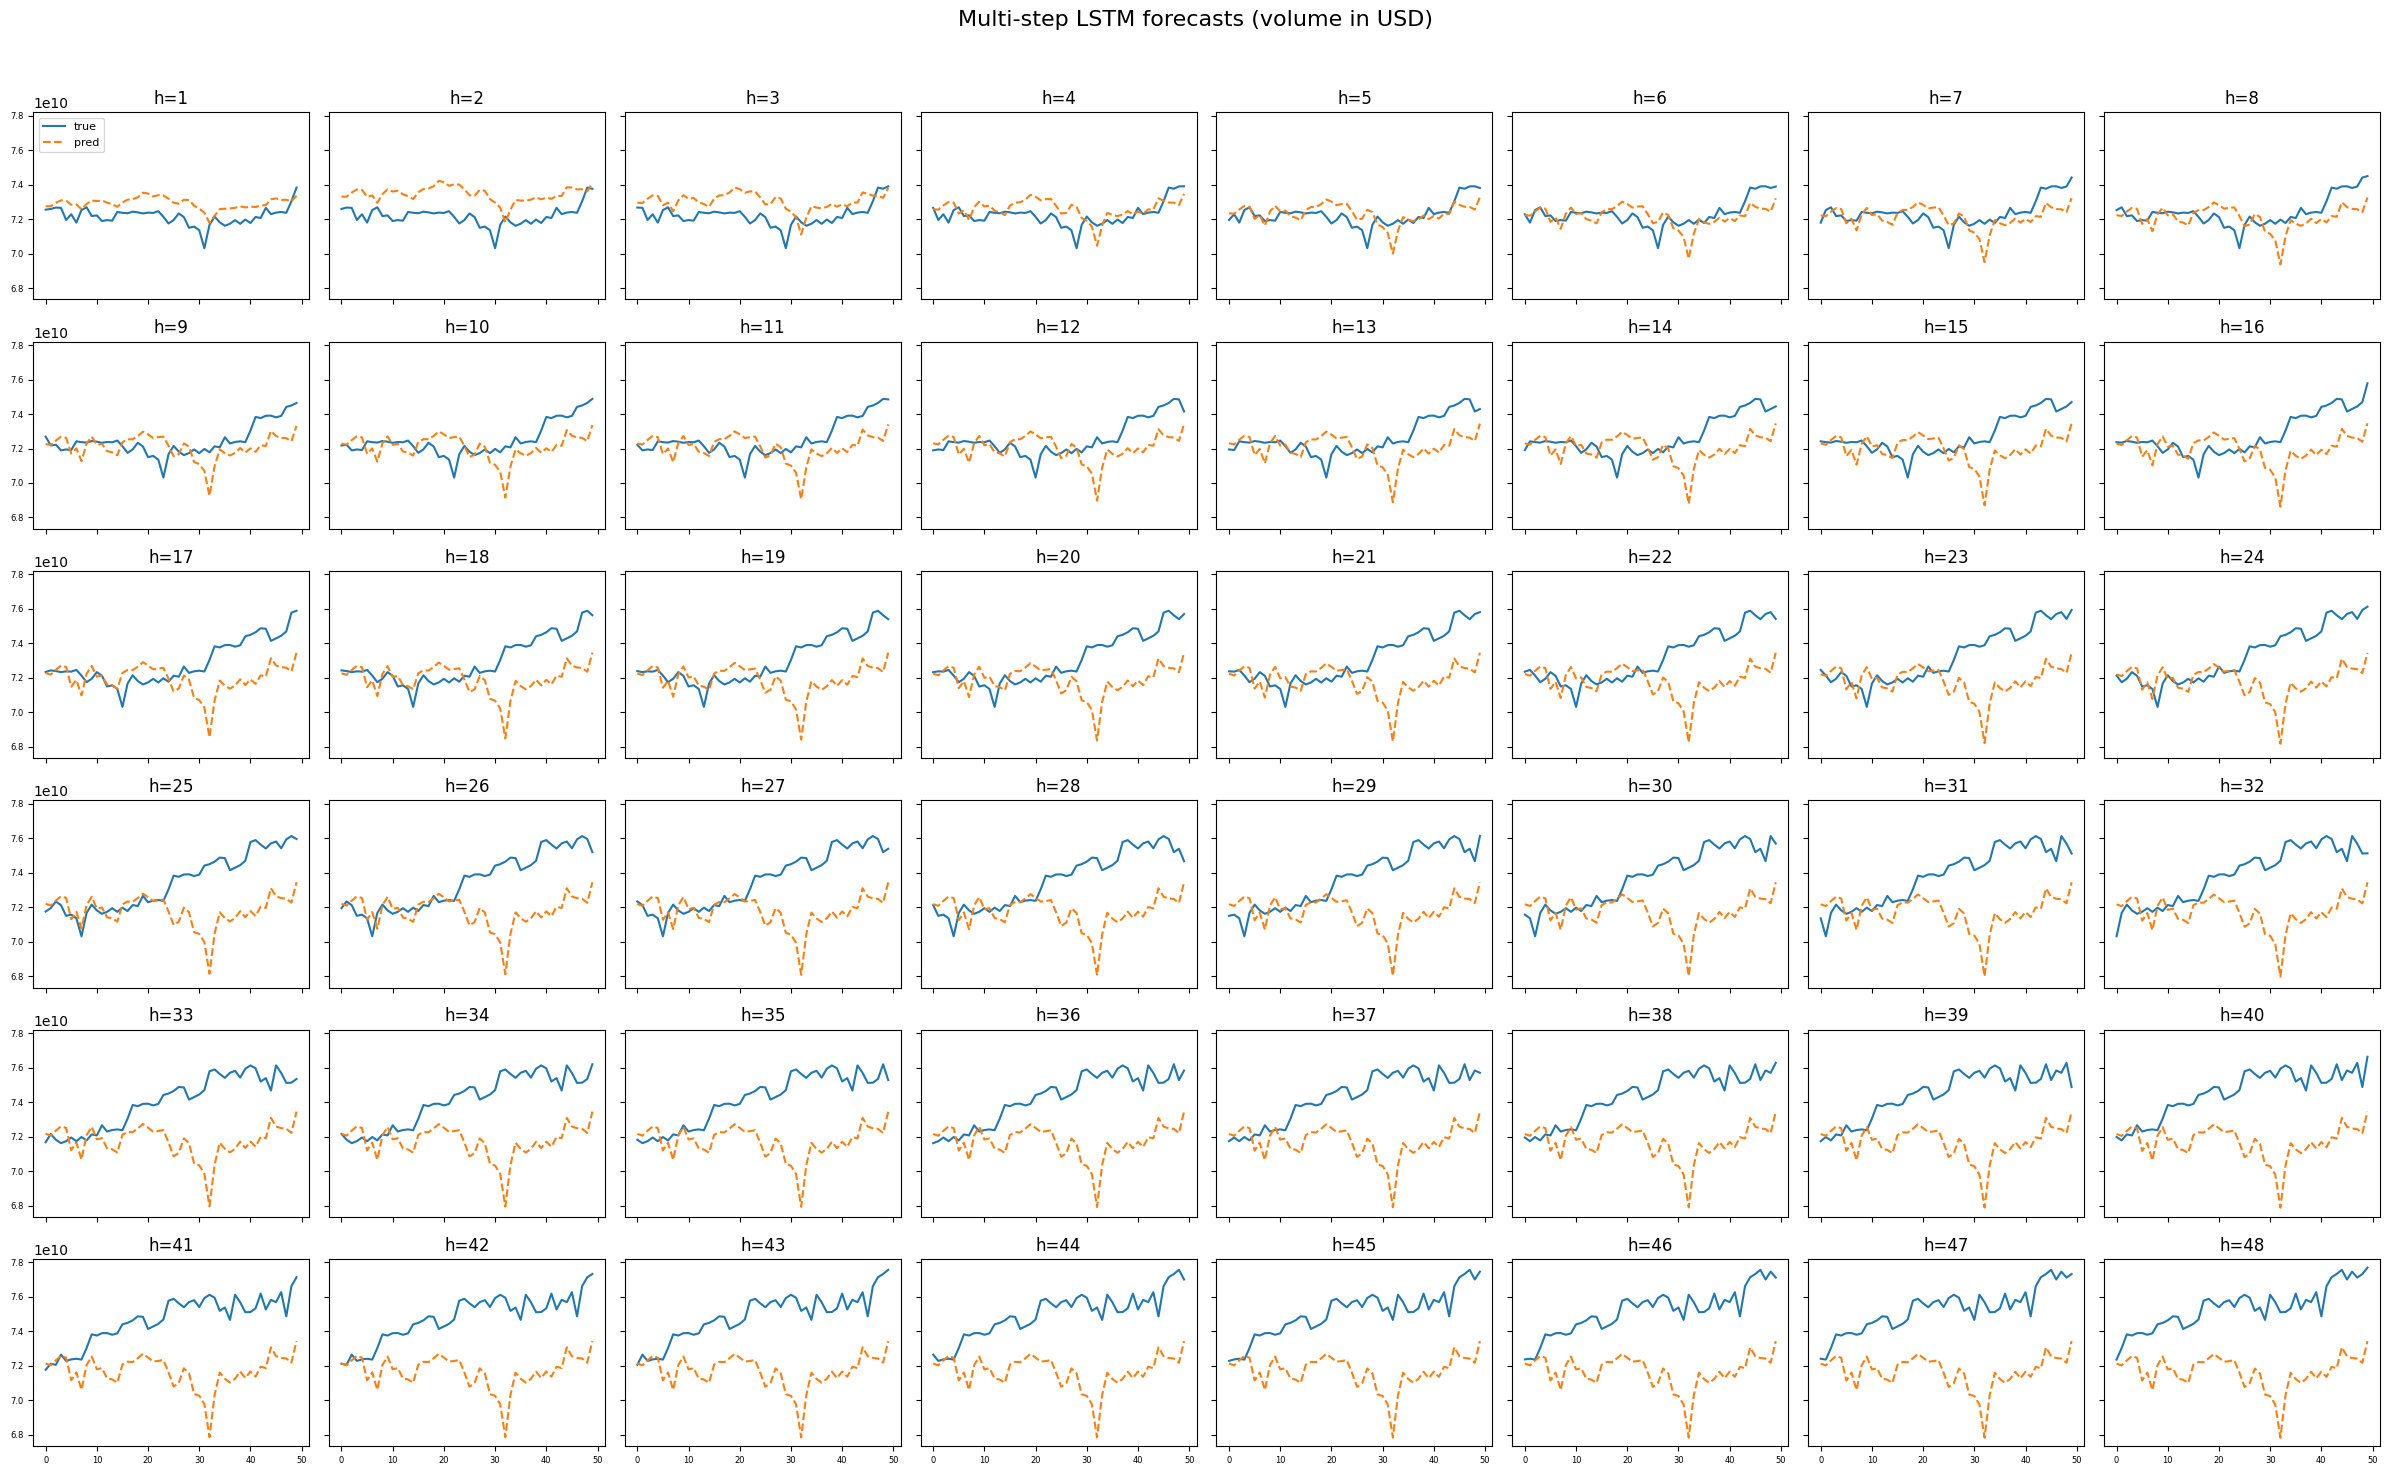

In [110]:
y_pred_scaled = model.predict(
    X_test,
    batch_size=64
)

y_pred_flat = y_pred_scaled.reshape(-1, n_ahead)

y_pred_log = scaler_y.inverse_transform(y_pred_flat)
y_test_log = scaler_y.inverse_transform(
    y_test.reshape(-1, n_ahead)
)

y_pred_vol = np.exp(y_pred_log)
y_test_vol = np.exp(y_test_log)

from sklearn.metrics import mean_absolute_error, r2_score

for h in range(n_ahead):
    mae = mean_absolute_error(y_test_vol[:, h], y_pred_vol[:, h])
    r2  = r2_score         (y_test_vol[:, h], y_pred_vol[:, h])
    print(f"Step {h+1:2d} — MAE: {mae:,.0f} USD,  R²: {r2:.4f}")

K = 50
cols = 8
rows = math.ceil(n_ahead/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5), sharex=True, sharey=True)
axes = axes.flatten()

for h in range(n_ahead):
    ax = axes[h]
    ax.plot(y_test_vol[:K, h],    color="C0", label="true")
    ax.plot(y_pred_vol[:K, h], "--", color="C1", label="pred")
    ax.set_title(f"h={h+1}")
    ax.tick_params(labelsize=6)

for ax in axes[n_ahead:]:
    ax.axis("off")

fig.suptitle("Multi‑step LSTM forecasts (volume in USD)", fontsize=16)
axes[0].legend(loc="upper left", fontsize=8)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [114]:
rolling_window = 12

df["log_total_cap"] = np.log(df["total_market_cap"])
df["log_altcoin_cap"] = np.log(df["altcoin_market_cap"])

df["vol_mean_12"] = df["log_val"].rolling(window=rolling_window).mean()
df["vol_std_12"] = df["log_val"].rolling(window=rolling_window).std()
df["alt_mean_12"] = df["log_alt_val"].rolling(window=rolling_window).mean()
df["alt_std_12"] = df["log_alt_val"].rolling(window=rolling_window).std()

df["cap_mean_12"] = df["log_total_cap"].rolling(window=rolling_window).mean()
df["cap_std_12"] = df["log_total_cap"].rolling(window=rolling_window).std()

df["vol_pct_1"] = df["log_val"].pct_change(periods=1)
df["alt_pct_1"] = df["log_alt_val"].pct_change(periods=1)

df["vol_to_cap"] = df["total_volume_24h"] / df["total_market_cap"]
df["alt_to_cap"] = df["altcoin_volume_24h"] / df["altcoin_market_cap"]

df = df.dropna().reset_index(drop=True)

feature_cols = [
    "log_val", "log_alt_val",
    "log_total_cap", "log_altcoin_cap",
    "vol_mean_12", "vol_std_12",
    "alt_mean_12", "alt_std_12",
    "cap_mean_12", "cap_std_12",
    "vol_pct_1", "alt_pct_1",
    "vol_to_cap", "alt_to_cap"
]

In [115]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

X, y = make_multi_step(df, feature_cols, "log_val", n_lags=48, forecast_horizon=48)

n_samples, n_timesteps, n_features = X.shape
X2 = X.reshape(-1, n_features)
scaler_x = MinMaxScaler().fit(X2)
X_scaled = scaler_x.transform(X2).reshape(n_samples, n_timesteps, n_features)

scaler_y = MinMaxScaler().fit(y)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [116]:
from keras import Input
from tensorflow.keras.models import Model

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_ahead = y_train.shape[1]

encoder_inputs = Input(shape=(n_timesteps, n_features))

# encoder
x = LSTM(128, return_sequences=False)(encoder_inputs)
x = Dropout(0.3)(x)

#decoder
x = RepeatVector(n_ahead)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.3)(x)

decoder_outputs = TimeDistributed(Dense(1))(x)

model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train.reshape(-1, n_ahead, 1),
    validation_data=(X_test, y_test.reshape(-1, n_ahead, 1)),
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
        )
    ],
    verbose=1,
)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 48, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128)            │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 48, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 48, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0318 - val_loss: 0.0013
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0056 - val_loss: 8.2668e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0033 - val_loss: 7.8303e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0025 - val_loss: 8.8780e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0024 - val_loss: 9.0457e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0022 - val_loss: 7.5668e-0

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Step  1 — MAE: 2,961,618,548 USD,  R²: 0.8636
Step  2 — MAE: 1,546,200,791 USD,  R²: 0.9595
Step  3 — MAE: 1,862,378,650 USD,  R²: 0.9436
Step  4 — MAE: 1,633,922,285 USD,  R²: 0.9538
Step  5 — MAE: 1,484,796,615 USD,  R²: 0.9599
Step  6 — MAE: 1,457,515,963 USD,  R²: 0.9605
Step  7 — MAE: 1,485,397,365 USD,  R²: 0.9582
Step  8 — MAE: 1,548,900,603 USD,  R²: 0.9544
Step  9 — MAE: 1,623,608,683 USD,  R²: 0.9501
Step 10 — MAE: 1,700,939,080 USD,  R²: 0.9455
Step 11 — MAE: 1,771,998,727 USD,  R²: 0.9409
Step 12 — MAE: 1,846,212,653 USD,  R²: 0.9363
Step 13 — MAE: 1,913,204,555 USD,  R²: 0.9319
Step 14 — MAE: 1,979,600,707 USD,  R²: 0.9276
Step 15 — MAE: 2,042,935,408 USD,  R²: 0.9235
Step 16 — MAE: 2,109,618,897 USD,  R²: 0.9194
Step 17 — MAE: 2,170,553,369 USD,  R²: 0.9154
Step 18 — MAE: 2,231,075,256 USD,  R²: 0.9114
Step 19 — MAE: 2,286,887,793 USD,  R²: 0.9076
Step 20 — MAE: 2,338,081,694 USD,  R²: 0.9042
Step 21 — MAE: 2,387,331,878 USD,  R²: 0

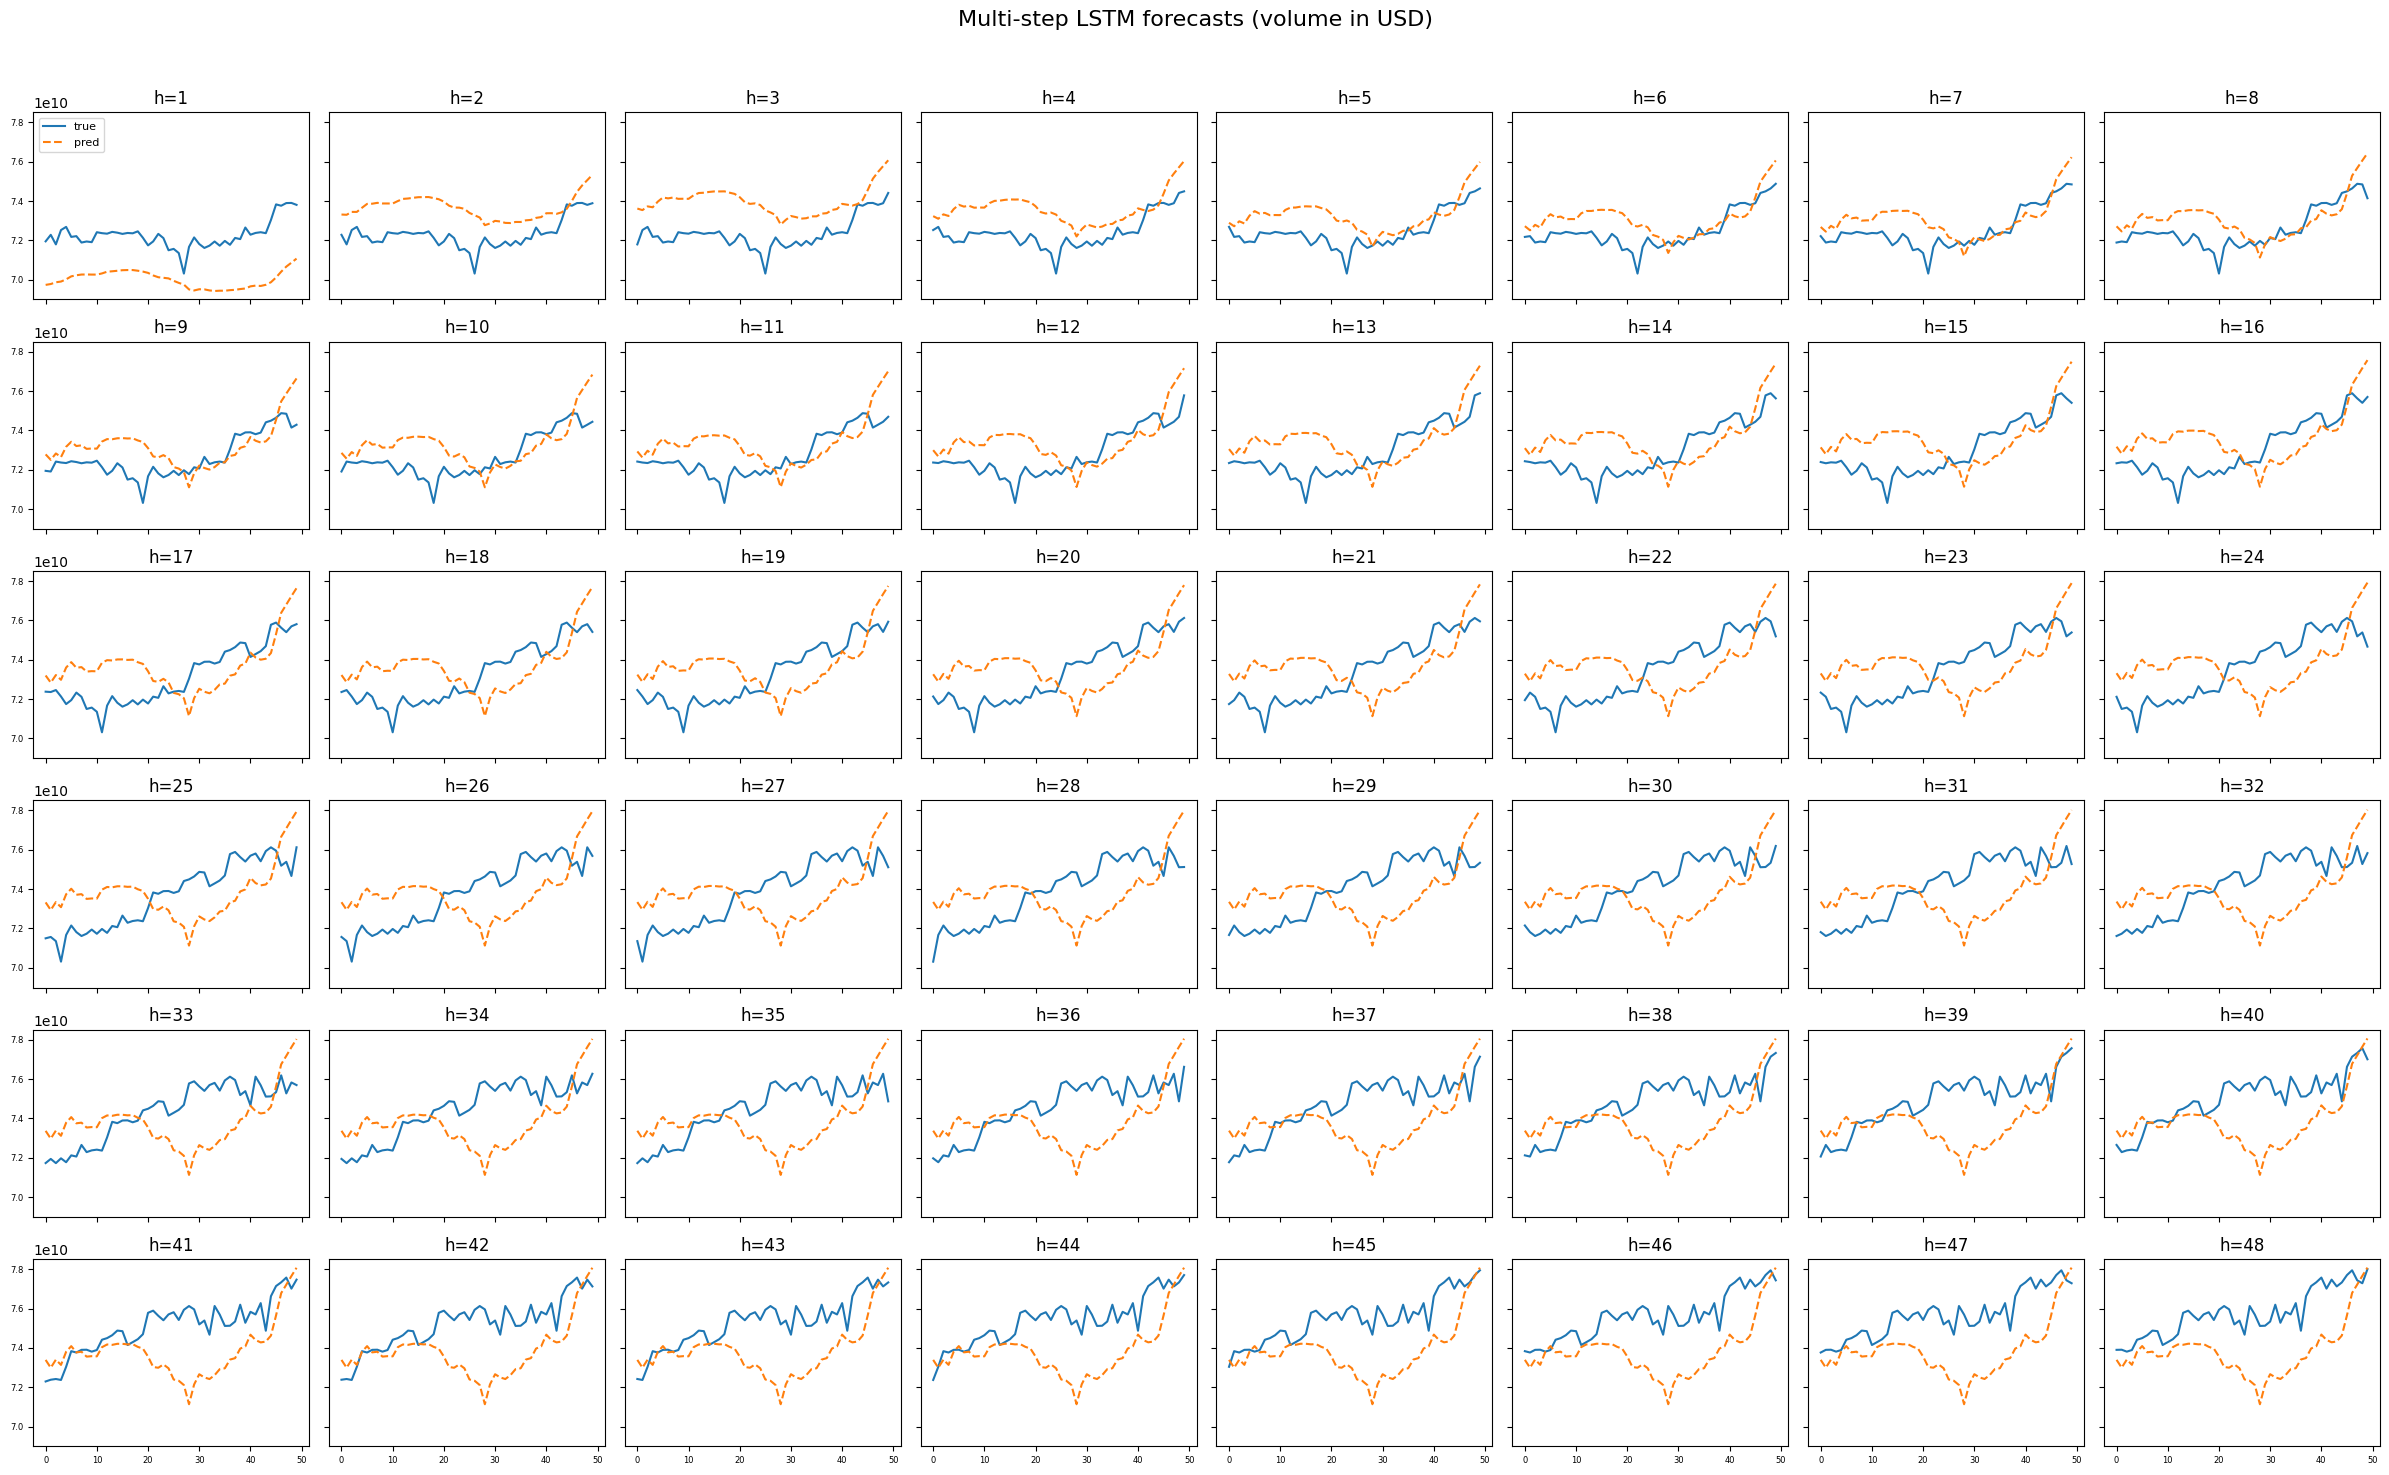

In [117]:
y_pred_scaled = model.predict(
    X_test,
    batch_size=64
)

y_pred_flat = y_pred_scaled.reshape(-1, n_ahead)

y_pred_log = scaler_y.inverse_transform(y_pred_flat)
y_test_log = scaler_y.inverse_transform(
    y_test.reshape(-1, n_ahead)
)

y_pred_vol = np.exp(y_pred_log)
y_test_vol = np.exp(y_test_log)

from sklearn.metrics import mean_absolute_error, r2_score

for h in range(n_ahead):
    mae = mean_absolute_error(y_test_vol[:, h], y_pred_vol[:, h])
    r2  = r2_score         (y_test_vol[:, h], y_pred_vol[:, h])
    print(f"Step {h+1:2d} — MAE: {mae:,.0f} USD,  R²: {r2:.4f}")

K = 50
cols = 8
rows = math.ceil(n_ahead/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5), sharex=True, sharey=True)
axes = axes.flatten()

for h in range(n_ahead):
    ax = axes[h]
    ax.plot(y_test_vol[:K, h],    color="C0", label="true")
    ax.plot(y_pred_vol[:K, h], "--", color="C1", label="pred")
    ax.set_title(f"h={h+1}")
    ax.tick_params(labelsize=6)

for ax in axes[n_ahead:]:
    ax.axis("off")

fig.suptitle("Multi‑step LSTM forecasts (volume in USD)", fontsize=16)
axes[0].legend(loc="upper left", fontsize=8)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
